This notebook uses several different models to predict popularity using likes/views as popularity calculation. Additionally, this notebook uses topics as a predictor.

In [46]:
import numpy as np
import pandas as pd
import ast
from collections import OrderedDict
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

In [49]:
df = pd.read_csv("..\data\data_sentiment_analysis.csv")
#df = df[0:20]
df.describe()

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,views,tb_score,vd_score
count,5631.000000,5631.000000,5631.000000,5631.000000,5.631000e+03,5.631000e+03,5631.000000,5631.000000
mean,2815.000000,2815.000000,25686.568460,707.691529,6.336276e+04,2.130394e+06,0.095959,0.656567
std,1625.674014,1625.674014,29649.007114,521.179373,1.089003e+05,3.679481e+06,0.068462,0.635958
min,0.000000,0.000000,1.000000,60.000000,1.700000e+01,5.870000e+02,-0.259643,-0.999900
25%,1407.500000,1407.500000,1642.500000,355.000000,2.000000e+04,6.781540e+05,0.049485,0.790400
50%,2815.000000,2815.000000,9807.000000,682.000000,4.100000e+04,1.392074e+06,0.098674,0.996300
75%,4222.500000,4222.500000,50009.500000,926.500000,6.500000e+04,2.182300e+06,0.140476,0.999300
max,5630.000000,5630.000000,95714.000000,20404.000000,2.200000e+06,7.338914e+07,0.594444,1.000000


In [50]:
# create popularity column by dividing likes and views
df['popularity'] = (df['likes']/df['views']) * 100

# Let's view the dataset again
df.head()
df['topics_list'] = df['topics_list'].apply(ast.literal_eval)
print(type(df['topics_list'][0]))
#print(type(df['topics'][0]))

<class 'list'>


In [51]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(df['topics_list'])
print(mlb.classes_)

['3D printing' 'AI' 'AIDS' 'Africa' "Alzheimer's" 'Antarctica'
 'Anthropocene' 'Asia' 'Audacious Project' 'Autism spectrum disorder'
 'Best of the Web' 'Big Bang' 'Brazil' 'Buddhism' 'CRISPR' 'Christianity'
 'Countdown' 'DNA' 'Egypt' 'Europe' 'Hinduism' 'Humanities' 'Internet'
 'Islam' 'Judaism' 'LGBTQIA+' 'Life' 'Mars' 'Middle East' 'Mission Blue'
 'Moon' 'NASA' 'NFTs' 'PTSD' 'Planets' 'Slavery' 'South America'
 'String theory' 'Sun' 'Surgery' 'TED Books' 'TED Connects' 'TED Fellows'
 'TED Membership' 'TED Prize' 'TED Residency' 'TED en Español' 'TED-Ed'
 'TEDMED' 'TEDx' 'Transgender' 'UX design' 'United States' 'Vaccines'
 'activism' 'addiction' 'aging' 'agriculture' 'algorithm' 'aliens'
 'ancient world' 'animals' 'animation' 'anthropology' 'archaeology'
 'architecture' 'art' 'asteroid' 'astrobiology' 'astronomy' 'atheism'
 'augmented reality' 'bacteria' 'beauty' 'bees' 'behavioral economics'
 'biodiversity' 'bioethics' 'biology' 'biomimicry' 'bionics' 'biosphere'
 'biotech' 'birds' 

In [52]:
# one hot encode the topics in the topics list
topics_encoded = pd.DataFrame(mlb.fit_transform(df['topics_list']), columns=mlb.classes_, index=df.index)
df_encoded = pd.concat([df, topics_encoded], axis=1).drop('topics_list', axis=1)
df_encoded

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,...,water,weather,wind energy,women,women in business,work,work-life balance,worklife,writing,youth
0,0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,...,0,0,0,0,0,0,0,0,0,0
2,2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",New York Times columnist David Pogue takes aim...,"[{'id': '10', 'name': 'technology'}, {'id': '3...",Simplicity sells,...,0,0,0,0,0,0,0,0,0,0
3,3,3,47,1126,80000,"[{'name': 'David Deutsch', 'occupation': 'Phys...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",Legendary scientist David Deutsch puts theoret...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Chemical scum that dream of distant quasars,...,0,0,0,0,0,0,0,0,0,0
4,4,4,55,1524,14000,"[{'name': 'Jehane Noujaim', 'occupation': 'Fil...","[{'name': 'English', 'code': 'en'}, {'name': '...",Jehane Noujaim unveils her 2006 TED Prize wish...,"[{'id': '4', 'name': 'culture'}, {'id': '6', '...",My wish: A global day of film,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,5626,5626,95714,278,5800,"[{'name': 'Lyla Latif', 'occupation': 'Educato...","[{'name': 'English', 'code': 'en'}, {'name': '...","In 2020, Mali produced over 71 tons of gold— a...","[{'id': '18', 'name': 'business'}, {'id': '19'...",The true cost of gold,...,0,0,0,0,0,0,0,0,0,0
5627,5627,5627,95710,940,10000,"[{'name': 'Trish Millines Dziko', 'occupation'...","[{'name': 'English', 'code': 'en'}, {'name': '...","Forget home economics and standardized tests, ...","[{'id': '52', 'name': 'education'}, {'id': '53...",How schools can nurture every student's genius,...,0,0,0,0,0,0,0,0,0,1
5628,5628,5628,95451,1048,12000,"[{'name': 'David Wengrow', 'occupation': 'Arch...","[{'name': 'English', 'code': 'en'}, {'name': '...",What if the commonly accepted narratives about...,"[{'id': '4', 'name': 'culture'}, {'id': '81', ...",A new understanding of human history and the r...,...,0,0,0,0,0,0,0,0,0,0
5629,5629,5629,95708,651,7200,"[{'name': 'Dan Widmaier', 'occupation': 'Bioma...","[{'name': 'English', 'code': 'en'}]",Your closet is likely full of all kinds of mat...,"[{'id': '5', 'name': 'environment'}, {'id': '8...",The future of fashion -- made from mushrooms,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# view columns
df_encoded.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 '_id',
 'duration',
 'likes',
 'speakers',
 'subtitle_languages',
 'summary',
 'topics',
 'title',
 'transcript',
 'views',
 'recorded_date',
 'published_date',
 'speakers_list',
 'sl_list',
 'processed_transcript',
 'tb_score',
 'vd_score',
 'popularity',
 '3D printing',
 'AI',
 'AIDS',
 'Africa',
 "Alzheimer's",
 'Antarctica',
 'Anthropocene',
 'Asia',
 'Audacious Project',
 'Autism spectrum disorder',
 'Best of the Web',
 'Big Bang',
 'Brazil',
 'Buddhism',
 'CRISPR',
 'Christianity',
 'Countdown',
 'DNA',
 'Egypt',
 'Europe',
 'Hinduism',
 'Humanities',
 'Internet',
 'Islam',
 'Judaism',
 'LGBTQIA+',
 'Life',
 'Mars',
 'Middle East',
 'Mission Blue',
 'Moon',
 'NASA',
 'NFTs',
 'PTSD',
 'Planets',
 'Slavery',
 'South America',
 'String theory',
 'Sun',
 'Surgery',
 'TED Books',
 'TED Connects',
 'TED Fellows',
 'TED Membership',
 'TED Prize',
 'TED Residency',
 'TED en Español',
 'TED-Ed',
 'TEDMED',
 'TEDx',
 'Transgender',
 'UX design',
 'United S

In [53]:
# eliminate columns from dataset that we do not need for model
X = df_encoded.drop(['_id', 'likes', 'published_date', 'recorded_date', 'speakers', 'subtitle_languages', 'summary', 'title', 'topics', 'transcript','views', 'speakers_list','sl_list','processed_transcript', 'popularity'], axis=1)
# assign the y variable to be popularity
y = df_encoded['popularity']

In [54]:
# split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression

In [56]:
from sklearn import linear_model

In [57]:
# fit model using scaled training data
reg = linear_model.LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_train_scaled, y_train)

0.11638753711477001

In [65]:
# predict y value and calculate mse
y_pred_linear = reg.predict(X_test_scaled)
mse_linear = np.mean((y_pred_linear - y_test) ** 2)
mse_linear

0.0015925376330652398

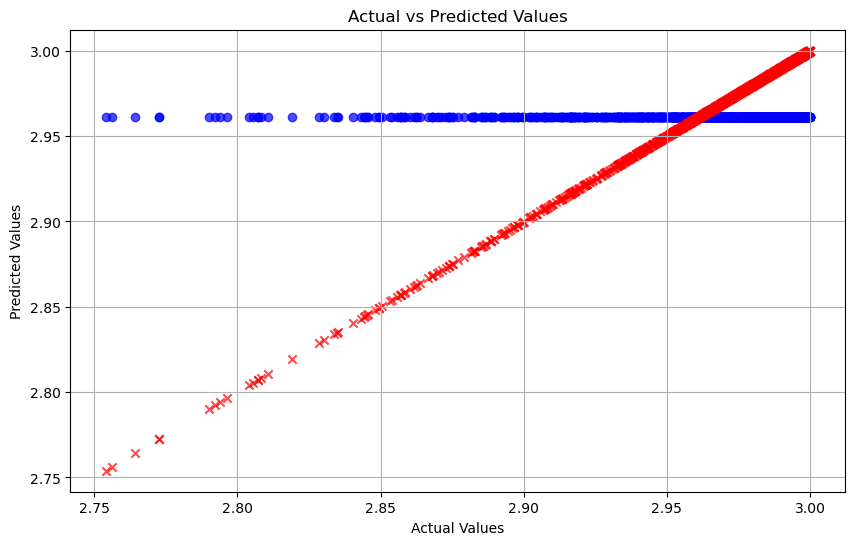

In [66]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Lasso Regression

In [61]:
reg = linear_model.Lasso(alpha=1)
reg.fit(X_train_scaled, y_train)


Lasso(alpha=1)

In [62]:
# predict popularity using lasso regression
y_pred_lasso = reg.predict(X_test_scaled)
mse_lasso = np.mean((y_pred_lasso - y_test) ** 2)
mse_lasso

0.0015925376330652398

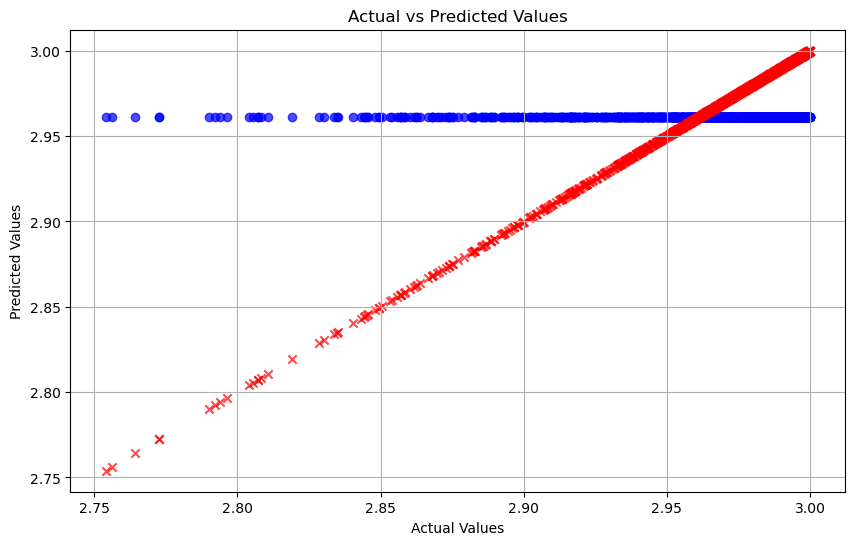

In [67]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_lasso  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Support Vector Regression

In [63]:
svr_linear = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_poly = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
svr_sigmoid = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

In [64]:
svr_linear.fit(X_train_scaled, y_train)
svr_rbf.fit(X_train_scaled, y_train)
svr_poly.fit(X_train_scaled, y_train)
svr_sigmoid.fit(X_train_scaled, y_train)

SVR(kernel='sigmoid')

In [68]:
y_pred_linear = svr_linear.predict(X_test_scaled)
y_pred_rbf = svr_rbf.predict(X_test_scaled)
y_pred_poly = svr_poly.predict(X_test_scaled)
y_pred_sigmoid = svr_sigmoid.predict(X_test_scaled)

In [69]:
mse_linear = np.mean((y_pred_linear - y_test) ** 2)
mse_linear

0.0037086530230998963

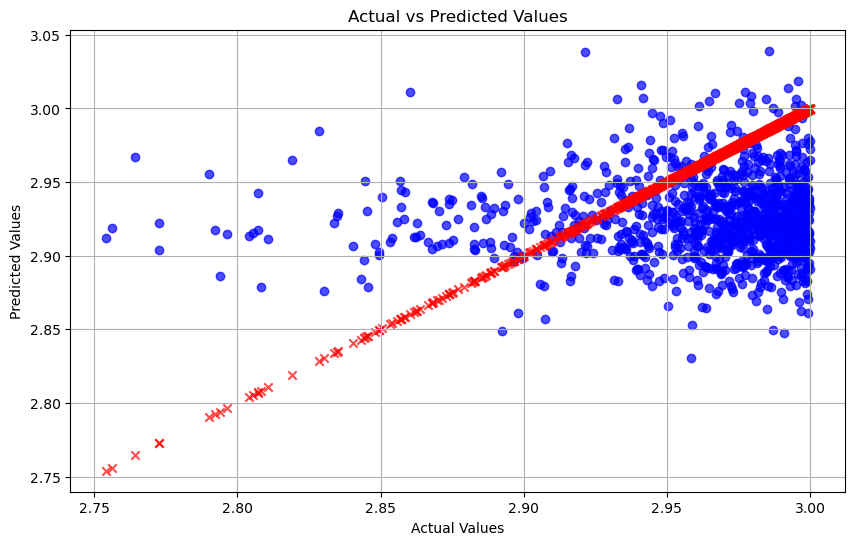

In [70]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [42]:
mse_rbf = np.mean((y_pred_rbf - y_test) ** 2)
mse_rbf

0.00543447417257449

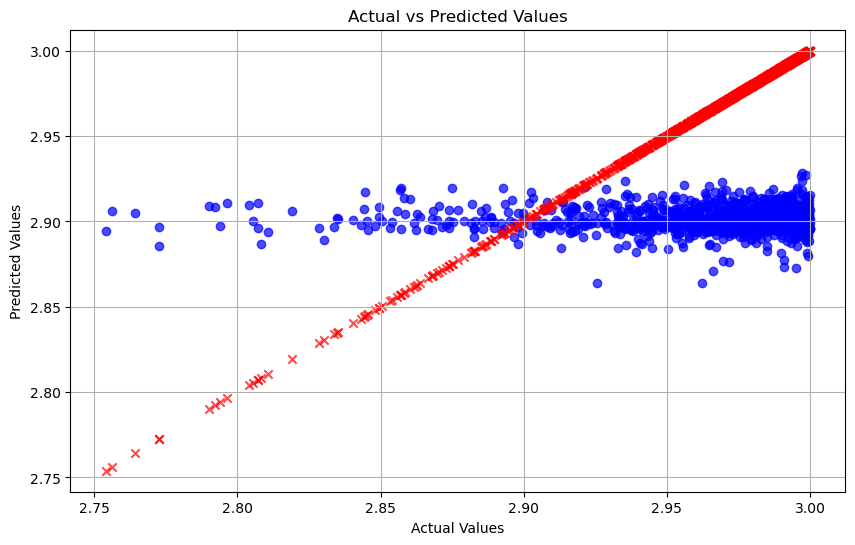

In [71]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_rbf  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [43]:
mse_poly = np.mean((y_pred_poly - y_test) ** 2)
mse_poly

0.005794260709929343

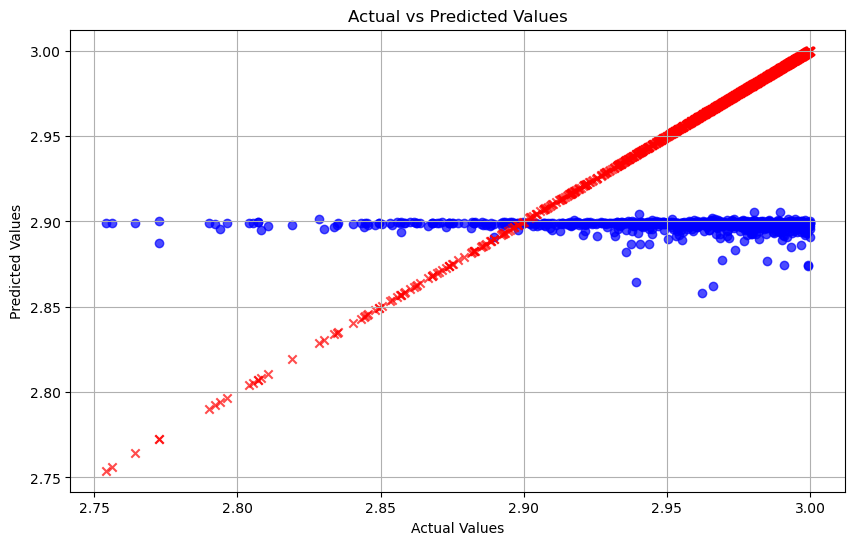

In [72]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_poly  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [44]:
mse_sigmoid = np.mean((y_pred_sigmoid - y_test) ** 2)
mse_sigmoid

0.28195086689593246

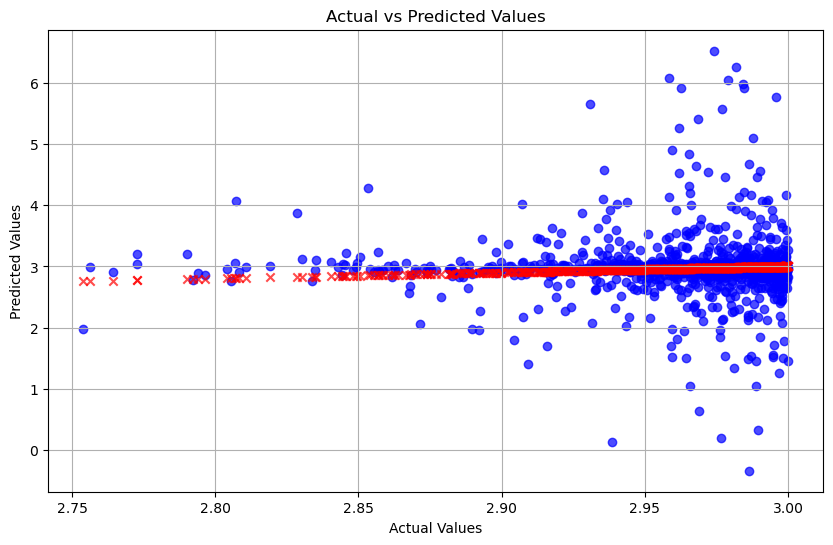

In [73]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_sigmoid  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()